#Paqueterias

In [ ]:
pip install folium

In [ ]:
import pandas as pd
import numpy as np
from numpy.random import choice, randint
from collections import deque, defaultdict
import matplotlib.pyplot as plt
import geopy
import networkx as nx
import folium
import pickle

#Extrayendo los datos

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/LuisMaanuel/Puntos_Conectividad/main/2023-11-23-puntos_de_acceso_wifi.csv')
data.head()

,id,programa,fecha_instalacion,latitud,longitud,colonia,alcaldia
0,19 DE MAYO-01,Colonias_Periféricas,NaN,19.362606,-99.25295626,19 DE MAYO,Álvaro Obregón
1,1A AMPLIACION SANTIAGO ACAHUALTEPEC-01,Colonias_Periféricas,NaN,19.352540,-99.01039,1A AMPLIACION SANTIAGO ACAHUALTEPEC,Iztapalapa
2,1A AMPLIACION SANTIAGO ACAHUALTEPEC-02,Colonias_Periféricas,NaN,19.351251,-99.00999147,1A AMPLIACION SANTIAGO ACAHUALTEPEC,Iztapalapa
3,SAN LORENZO ACOPILCO (PBLO)-01,Colonias_Periféricas,NaN,19.331898,-99.32573767,SAN LORENZO ACOPILCO (PBLO),Cuajimalpa de Morelos
4,26 DE JULIO-01,Colonias_Periféricas,NaN,19.357752,-99.25105,26 DE JULIO,Álvaro Obregón


In [ ]:
data.programa.unique()

array(['Colonias_Periféricas', 'AICM_T1', 'AICM_T2', 'Cablebús_L1',
       'Centros_de_Salud', 'Cablebús_L2', 'Escuelas Primarias',
       'Escuelas Secundarias', 'IEMS', 'Metrobús', 'Mi_Calle', 'PILARES',
       'Postes_C5', 'Sitios_Publicos', 'Unidades_Habitacionales',
       'Universidades', 'UTOPIAS_Iztapalapa', 'Escuelas_Normales ',
       'CETRAMS', 'Hospitales', 'HOSPITALES'], dtype=object)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32497 entries, 0 to 32496
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 32497 non-null  object 
 1   programa           32497 non-null  object 
 2   fecha_instalacion  0 non-null      float64
 3   latitud            32497 non-null  float64
 4   longitud           32497 non-null  object 
 5   colonia            32497 non-null  object 
 6   alcaldia           32497 non-null  object 
dtypes: float64(2), object(5)
memory usage: 1.7+ MB


Notese que la unica columna que tiene todos sus datos faltantes es ```fecha_instalacion``` pero las unicas columnas que vamos a necesitar para generar nuestra  grafica son ```latitud,longitud```

In [ ]:
print('Porcentaje de datos null\n',data.isnull().sum()/len(data))
print('\n\nPorcentaje de datos NaN\n',data.isna().sum()/len(data))

Porcentaje de datos null
 id                   0.0
programa             0.0
fecha_instalacion    1.0
latitud              0.0
longitud             0.0
colonia              0.0
alcaldia             0.0
dtype: float64


Porcentaje de datos NaN
 id                   0.0
programa             0.0
fecha_instalacion    1.0
latitud              0.0
longitud             0.0
colonia              0.0
alcaldia             0.0
dtype: float64


In [ ]:
coordenadas = data[['latitud','longitud']]
coordenadas.head()

,latitud,longitud
0,19.362606,-99.25295626
1,19.352540,-99.01039
2,19.351251,-99.00999147
3,19.331898,-99.32573767
4,19.357752,-99.25105


In [ ]:
coordenadas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32497 entries, 0 to 32496
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   latitud   32497 non-null  float64
 1   longitud  32497 non-null  object 
dtypes: float64(1), object(1)
memory usage: 507.9+ KB


vamos a convertir los datos a float para poder generar nuestro mapa y grafica posteriormente.

In [ ]:
coordenadas['longitud'] = coordenadas['longitud'].apply(lambda x: float(''.join(x.split())))
# coordenadas['longitud'] = coordenadas['longitud'].apply(lambda x: float(x))

<ipython-input-69-99494987e8a0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coordenadas['longitud'] = coordenadas['longitud'].apply(lambda x: float(''.join(x.split())))


In [ ]:
coordenadas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32497 entries, 0 to 32496
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   latitud   32497 non-null  float64
 1   longitud  32497 non-null  float64
dtypes: float64(2)
memory usage: 507.9 KB


In [ ]:
coordenadas['id'] = range(1,len(coordenadas)+1)
coordenadas.head()

<ipython-input-71-8a3020cad82b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coordenadas['id'] = range(1,len(coordenadas)+1)


,latitud,longitud,id
0,19.362606,-99.252956,1
1,19.352540,-99.010390,2
2,19.351251,-99.009991,3
3,19.331898,-99.325738,4
4,19.357752,-99.251050,5


In [ ]:
## diccionario de ubicaciones
pos = dict()

for lat, longitud, id in coordenadas.values:
  pos[id] = (lat,longitud)
len(pos)

32497

#creacion del mapa

In [ ]:
m = folium.Map(location=(19.4361609, -99.1373136),zoom_start=12)
m

In [ ]:
for latitud,longitud,_ in coordenadas.values:
  folium.Circle(location=[latitud, longitud], radius=35,
                color='red').add_to(m)
  folium.CircleMarker(location=[latitud, longitud], radius=3
                      , color='red').add_to(m)
m.save('PuntosyRango.html')

#Funcion para calcular distancia

Primero vamos a definir una funcion que nos ayuda a calcular la distancia en metros entre dos coordenadas geograficas. Esta funcion es de gran iportancia, pues con ella vamos a decir si dos puntos en nuestra grafica estan conectados o no si su distancia es mayor a 30 metros pues elradio del wifi en promedio son 15 metros.


Esta distancia se puede calcular de con las funciones ```geodesic,distance,great_cirlce``` del modulo ```geopy.distance```


* ```geodesic``` Usa la distancia de la geodesica sobre un modelo elipsoidal de la tierra mediante el algoritmo de Karney.

* ```distance``` Usa la distancia de la geodesica sobre el modelo elipsoidal de la tierra mas aceptado mundialmente.

* ```great_circle``` Usa la distancia de la geodesica sobre un modelo esferico de la tierra y nos a un error de medicion del 0.5%.

Todas estas son distincas formas de calcular la distancia de dos puntos, pero como nuestro dataset es de casi 35,000 registros buscamos la que tenga el mejor tiempo posible pues las distancias que nos regresan son bastante semejantes. Por lo cual se realizara el calculo de Berlin hasta Paris unas 100,000 veces para medir el tiepo promedio con ```timeit``` y asi decirdir cual es mejor en cuestion de tiempo

In [ ]:
from geopy.distance import geodesic

berlin=[52.5200,13.4050]
paris = [48.8566,2.3522]

print('Distancia en metros entre Berlin y Paris',geodesic(berlin,paris).meters)

Distancia en metros entre Berlin y Paris 879699.3161290118


In [ ]:
# import numpy as np

def calcular_distancia(latitud1, longitud1, latitud2, longitud2):

    R = 6371  # Radio de la Tierra en kilómetros
    latitudes_rad = np.radians([latitud1, latitud2])
    longitudes_rad = np.radians([longitud1, longitud2])

    delta_latitudes = latitudes_rad[1] - latitudes_rad[0]
    delta_longitudes = longitudes_rad[1] - longitudes_rad[0]

    a = np.sin(delta_latitudes / 2)**2 + np.cos(latitudes_rad[0]) * np.cos(latitudes_rad[1]) * np.sin(delta_longitudes / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distancia = R * c *1000  # Distancia en metros
    return distancia

# Ejemplo de uso
latitud1 = 52.5200  # Latitud de Berlín, Alemania
longitud1 = 13.4050  # Longitud de Berlín, Alemania

latitud2 = 48.8566  # Latitud de París, Francia
longitud2 = 2.3522  # Longitud de París, Francia

distancia = calcular_distancia(latitud1,longitud1,latitud2,longitud2)
print(f"Distancia entre Berlín y París: {distancia:.2f} m")


Distancia entre Berlín y París: 877463.33 m


In [ ]:
from geopy.distance import distance, great_circle
import timeit
def calcular_distancia_geodesic(latitud1, longitud1, latitud2, longitud2):

  distancia = geodesic((latitud1, longitud1), (latitud2, longitud2)).meters
  return distancia

def wrapper_geodesic():
    return calcular_distancia_geodesic(latitud1, longitud1, latitud2, longitud2)
elapsed_time1 = timeit.timeit(wrapper_geodesic, number=100000)


def calcular_distancia_geopy(latitud1, longitud1, latitud2, longitud2):

  distancia = distance((latitud1, longitud1), (latitud2, longitud2)).meters
  return distancia


def wrapper_distance():
    return calcular_distancia_geopy(latitud1, longitud1, latitud2, longitud2)

elapsed_time2 = timeit.timeit(wrapper_distance, number=100000)




def calcular_distancia_cirlce(latitud1, longitud1, latitud2, longitud2):

  distancia = great_circle((latitud1, longitud1), (latitud2, longitud2)).meters
  return distancia

def wrapper_great():
    return calcular_distancia_cirlce(latitud1, longitud1, latitud2, longitud2)
elapsed_time3 = timeit.timeit(wrapper_great, number=100000)



def wrapper():
    return calcular_distancia(latitud1, longitud1, latitud2, longitud2)

elapsed_time4 = timeit.timeit(wrapper, number=100000)

latitud1, longitud1 = 52.5200, 13.4050  # Berlín, Alemania
latitud2, longitud2 = 48.8566, 2.3522   # París, Francia
print(f"Distancia entre Berlín y París: {wrapper_distance():.2f} m")
print(f"Tiempo de ejecución con geodesic: {elapsed_time1:.6f} segundos")

print(f"Tiempo de ejecución con distance: {elapsed_time2:.6f} segundos")

print(f"Tiempo de ejecución con great_circle: {elapsed_time3:.6f} segundos")

print(f"Tiempo de ejecución con mi funcion: {elapsed_time4:.6f} segundos")

Distancia entre Berlín y París: 879699.32 m
Tiempo de ejecución con geodesic: 25.941510 segundos
Tiempo de ejecución con distance: 30.202357 segundos
Tiempo de ejecución con great_circle: 1.114010 segundos
Tiempo de ejecución con mi funcion: 1.318262 segundos


Podemos ver que es muchisimo mas rapido calcular la distancia con ```great_circle``` y con nuestra funcion ```calcular_distancia```. En este caso usaremos la primera pues en tiempo de ejecucion es la mas rapida ya que se esta probando 100,000 veces.

#Creacion de la grafica

In [ ]:
calcular_distancia_cirlce(coordenadas.iloc[0]['latitud'],coordenadas.iloc[0]['longitud']
                          ,coordenadas.iloc[1]['latitud'],coordenadas.iloc[1]['longitud'])

25471.993940762983

In [ ]:
len(coordenadas)

32497

Usando networkx

calculamos  la distancia de los primeros 6999 vertices contra todos los demas vertices

In [ ]:
G = nx.Graph()
for id1 in range(1,7000):
  print('iteracion sobre el vertice: ',id1)
  G.add_node(id1)
  # for id2 in range(1,32498):
  for id2 in range(id1,32498):
    G.add_node(id2)
    # print(id1,id2)
    dist = calcular_distancia_cirlce(pos[id1][0],pos[id1][1], pos[id2][0],pos[id2][1])
    if dist >0 and dist <=70:
      # print('       ',id1,id2,dist,'\n')
      G.add_edge(id1,id2)

Streaming output truncated to the last 5000 lines.
iteracion sobre el vertice:  2000
iteracion sobre el vertice:  2001
iteracion sobre el vertice:  2002
iteracion sobre el vertice:  2003
iteracion sobre el vertice:  2004
iteracion sobre el vertice:  2005
iteracion sobre el vertice:  2006
iteracion sobre el vertice:  2007
iteracion sobre el vertice:  2008
iteracion sobre el vertice:  2009
iteracion sobre el vertice:  2010
iteracion sobre el vertice:  2011
iteracion sobre el vertice:  2012
iteracion sobre el vertice:  2013
iteracion sobre el vertice:  2014
iteracion sobre el vertice:  2015
iteracion sobre el vertice:  2016
iteracion sobre el vertice:  2017
iteracion sobre el vertice:  2018
iteracion sobre el vertice:  2019
iteracion sobre el vertice:  2020
iteracion sobre el vertice:  2021
iteracion sobre el vertice:  2022
iteracion sobre el vertice:  2023
iteracion sobre el vertice:  2024
iteracion sobre el vertice:  2025
iteracion sobre el vertice:  2026
iteracion sobre el vertice:  20

In [ ]:
nx.write_graphml(G,"graph1.graphml")

In [ ]:
nx.draw_networkx(G,pos,node_color='red')

Calculando para el nodo 7,000 hasta 15,000

In [ ]:
G = nx.read_graphml('graph1.graphml',node_type=int)
for id1 in range(7000,15000):
  print('iteracion sobre el vertice: ',id1)
  G.add_node(id1)
  for id2 in range(id1,32498):
    G.add_node(id2)
    # print(id1,id2)
    dist = calcular_distancia_cirlce(pos[id1][0],pos[id1][1], pos[id2][0],pos[id2][1])
    if dist >0 and dist <=70:
      # print('       ',id1,id2,dist,'\n')
      G.add_edge(id1,id2)

nx.write_graphml(G,"graph2.graphml")

Se han truncado las últimas 5000 líneas del flujo de salida.
iteracion sobre el vertice:  10000
iteracion sobre el vertice:  10001
iteracion sobre el vertice:  10002
iteracion sobre el vertice:  10003
iteracion sobre el vertice:  10004
iteracion sobre el vertice:  10005
iteracion sobre el vertice:  10006
iteracion sobre el vertice:  10007
iteracion sobre el vertice:  10008
iteracion sobre el vertice:  10009
iteracion sobre el vertice:  10010
iteracion sobre el vertice:  10011
iteracion sobre el vertice:  10012
iteracion sobre el vertice:  10013
iteracion sobre el vertice:  10014
iteracion sobre el vertice:  10015
iteracion sobre el vertice:  10016
iteracion sobre el vertice:  10017
iteracion sobre el vertice:  10018
iteracion sobre el vertice:  10019
iteracion sobre el vertice:  10020
iteracion sobre el vertice:  10021
iteracion sobre el vertice:  10022
iteracion sobre el vertice:  10023
iteracion sobre el vertice:  10024
iteracion sobre el vertice:  10025
iteracion sobre el vertice:  

calculando para el 15,000 hasta el 25,000

Se han truncado las últimas 5000 líneas del flujo de salida.
iteracion sobre el vertice:  20000
iteracion sobre el vertice:  20001
iteracion sobre el vertice:  20002
iteracion sobre el vertice:  20003
iteracion sobre el vertice:  20004
iteracion sobre el vertice:  20005
iteracion sobre el vertice:  20006
iteracion sobre el vertice:  20007
iteracion sobre el vertice:  20008
iteracion sobre el vertice:  20009
iteracion sobre el vertice:  20010
iteracion sobre el vertice:  20011
iteracion sobre el vertice:  20012
iteracion sobre el vertice:  20013
iteracion sobre el vertice:  20014
iteracion sobre el vertice:  20015
iteracion sobre el vertice:  20016
iteracion sobre el vertice:  20017
iteracion sobre el vertice:  20018
iteracion sobre el vertice:  20019
iteracion sobre el vertice:  20020
iteracion sobre el vertice:  20021
iteracion sobre el vertice:  20022
iteracion sobre el vertice:  20023
iteracion sobre el vertice:  20024
iteracion sobre el vertice:  20025
iteracion sobre el vertice:  

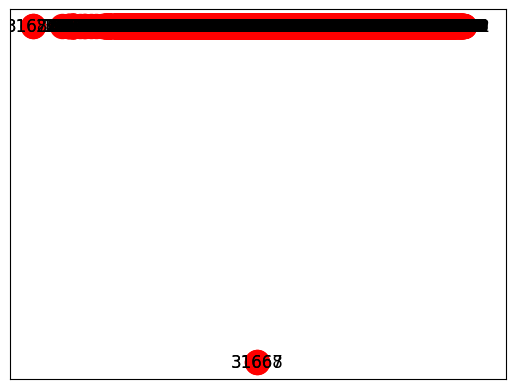

In [ ]:
G = nx.read_graphml('graph2.graphml',node_type=int)
for id1 in range(15000,25000):
  print('iteracion sobre el vertice: ',id1)
  G.add_node(id1)
  for id2 in range(id1,32498):
    G.add_node(id2)
    # print(id1,id2)
    dist = calcular_distancia_cirlce(pos[id1][0],pos[id1][1], pos[id2][0],pos[id2][1])
    if dist >0 and dist <=70:
      # print('       ',id1,id2,dist,'\n')
      G.add_edge(id1,id2)

nx.write_graphml(G,"graph3.graphml")
nx.draw_networkx(G,pos,node_color='red')

In [ ]:
# nt = Network("1000", "1000px", notebook=True)
# nt.from_nx(G)
# nt.toggle_physics(False)

# # %%capture
# nt.show("graph3.html")

Calculando para el 25,000 hasta el 30,000

In [ ]:
G = nx.read_graphml('graph3.graphml',node_type=int)
for id1 in range(25000,30000):
  print('iteracion sobre el vertice: ',id1)
  G.add_node(id1)#,latitud = pos[id1][0] ,longitud = pos[id1][1])
  for id2 in range(id1,32498):
    G.add_node(id2)#,latitud = pos[id2][0] ,longitud = pos[id2][1])
    # print(id1,id2)
    dist = calcular_distancia_cirlce(pos[id1][0],pos[id1][1], pos[id2][0],pos[id2][1])
    if dist >0 and dist <=70:
      # print('       ',id1,id2,dist,'\n')
      G.add_edge(id1,id2)

iteracion sobre el vertice:  25000
iteracion sobre el vertice:  25001
iteracion sobre el vertice:  25002
iteracion sobre el vertice:  25003
iteracion sobre el vertice:  25004
iteracion sobre el vertice:  25005
iteracion sobre el vertice:  25006
iteracion sobre el vertice:  25007
iteracion sobre el vertice:  25008
iteracion sobre el vertice:  25009
iteracion sobre el vertice:  25010
iteracion sobre el vertice:  25011
iteracion sobre el vertice:  25012
iteracion sobre el vertice:  25013
iteracion sobre el vertice:  25014
iteracion sobre el vertice:  25015
iteracion sobre el vertice:  25016
iteracion sobre el vertice:  25017
iteracion sobre el vertice:  25018
iteracion sobre el vertice:  25019
iteracion sobre el vertice:  25020
iteracion sobre el vertice:  25021
iteracion sobre el vertice:  25022
iteracion sobre el vertice:  25023
iteracion sobre el vertice:  25024
iteracion sobre el vertice:  25025
iteracion sobre el vertice:  25026
iteracion sobre el vertice:  25027
iteracion sobre el v

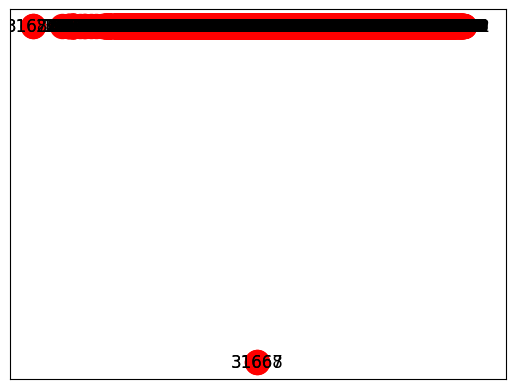

In [ ]:
nx.write_graphml(G, "graph4.graphml")
nx.draw_networkx(G,pos,node_color='red')

In [ ]:
# for node_id, position in pos.items():
#   # print(type(position[0]))
#   G.nodes[int(node_id)]['latitud'] = position[0]
#   G.nodes[int(node_id)]['longitud'] = position[1]

# nx.write_graphml(G, "graph4.graphml")
# nx.draw_networkx(G,pos,node_color='red')

Calculando desde el 30,00 hasta el nodo 32497

In [ ]:
G = nx.read_graphml('graph4.graphml',node_type=int)
for id1 in range(30000,len(pos)+1):
  print('iteracion sobre el vertice: ',id1)
  G.add_node(id1)#,latitud = pos[id1][0] ,longitud = pos[id1][1])
  for id2 in range(id1,32498):
    G.add_node(id2)#,latitud = pos[id2][0] ,longitud = pos[id2][1])
    # print(id1,id2)
    dist = calcular_distancia_cirlce(pos[id1][0],pos[id1][1], pos[id2][0],pos[id2][1])
    if dist >0 and dist <=70:
      # print('       ',id1,id2,dist,'\n')
      G.add_edge(id1,id2)

iteracion sobre el vertice:  30000
iteracion sobre el vertice:  30001
iteracion sobre el vertice:  30002
iteracion sobre el vertice:  30003
iteracion sobre el vertice:  30004
iteracion sobre el vertice:  30005
iteracion sobre el vertice:  30006
iteracion sobre el vertice:  30007
iteracion sobre el vertice:  30008
iteracion sobre el vertice:  30009
iteracion sobre el vertice:  30010
iteracion sobre el vertice:  30011
iteracion sobre el vertice:  30012
iteracion sobre el vertice:  30013
iteracion sobre el vertice:  30014
iteracion sobre el vertice:  30015
iteracion sobre el vertice:  30016
iteracion sobre el vertice:  30017
iteracion sobre el vertice:  30018
iteracion sobre el vertice:  30019
iteracion sobre el vertice:  30020
iteracion sobre el vertice:  30021
iteracion sobre el vertice:  30022
iteracion sobre el vertice:  30023
iteracion sobre el vertice:  30024
iteracion sobre el vertice:  30025
iteracion sobre el vertice:  30026
iteracion sobre el vertice:  30027
iteracion sobre el v

In [ ]:
nx.write_graphml(G, "graph5.graphml")

In [ ]:
grafica1 = nx.read_graphml('graph5.graphml',node_type=int)
for id, info in grafica1.nodes(data=True):
  info['latitud'] = pos[id][0]
  info['longitud'] = pos[id][1]
nx.write_graphml(grafica1,'grapfica5_coordenadas_org.graphml')

In [ ]:
### agregando las coordenadas a los nodos
grafica = nx.read_graphml('graph5.graphml',node_type=int)

for node_id, info in grafica.nodes(data=True):
  info['latitud'] = pos[int(node_id)][0]*-10000
  info['longitud'] = pos[int(node_id)][1]*10000

nx.write_graphml(grafica,'graph5_neg_coordenadasx10000y10000.graphml')

# Mapa de la ciudad con vertices y aristas

In [ ]:
# m = folium.Map(location=(19.4361609, -99.1373136),zoom_start=12)
# for latitud,longitud,_ in coordenadas.values:
#   folium.CircleMarker(location=[latitud, longitud], radius=3, color='red').add_to(m)

In [ ]:
grafica1 = nx.read_graphml('graph5.graphml',node_type=int)
m = folium.Map(location=(19.4361609, -99.1373136),zoom_start=12)
for latitud,longitud,_ in coordenadas.values:
  folium.CircleMarker(location=[latitud, longitud], radius=3, color='red').add_to(m)
  folium.Circle(location=[latitud, longitud], radius=35,
                # fill_color="red",
                color='red').add_to(m)
for id1, id2 in grafica1.edges():
  folium.PolyLine(locations=[pos[id1] ,pos[id2]],color='blue').add_to(m)

m.save("Conexion_Internet.html")

In [ ]:
# for id1, id2 in grafica1.edges():
#   folium.PolyLine(locations=[pos[id1] ,pos[id2]],color='blue').add_to(m)

In [ ]:
# m.save("index.html")

#BFS y components

In [ ]:
marker_colors = ['blue','darkred','lightred',
    'orange','green','darkgreen','lightgreen',
    'darkblue','lightblue','purple','darkpurple',
    'pink','cadetblue','black']

custom_colors = {
    0: (0.0, 0.0, 1.0),         # blue
    1: (0.5450980392156862, 0.0, 0.0),  # darkred
    2: (1.0, 0.7137254901960784, 0.7568627450980392),  # lightred
    3: (1.0, 0.6470588235294118, 0.0),  # orange
    4: (0.0, 0.5019607843137255, 0.0),  # green
    5: (0.0, 0.39215686274509803, 0.0),  # darkgreen
    6: (0.5647058823529412, 0.9333333333333333, 0.5647058823529412),  # lightgreen
    7: (0.0, 0.0, 0.5450980392156862),  # darkblue
    8: (0.6784313725490196, 0.8470588235294118, 0.9019607843137255),  # lightblue
    9: (0.5019607843137255, 0.0, 0.5019607843137255),  # purple
    10: (0.2941176470588235, 0.0, 0.5098039215686274),  # darkpurple
    11: (1.0, 0.7529411764705882, 0.796078431372549),  # pink
    12: (0.37254901960784315, 0.6196078431372549, 0.6274509803921569),  # cadetblue
    13: (0.0, 0.0, 0.0)  # black
}

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:437: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


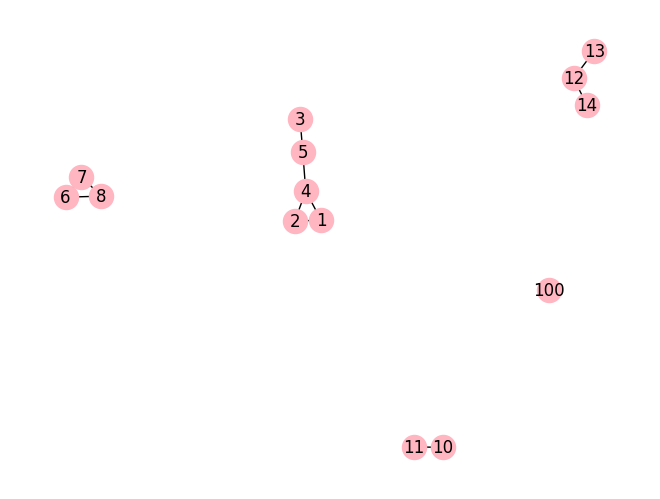

In [ ]:
##          grafica de prueba para BFS y components


graph = nx.Graph()
graph.add_edge(1,2)
graph.add_edge(1,4)
graph.add_edge(4,2)
graph.add_edge(5,3)
graph.add_edge(4,5)

graph.add_node(100)

graph.add_edge(6,7)
graph.add_edge(7,8)
graph.add_edge(6,8)

graph.add_edge(10,11)

graph.add_edge(12,13)
graph.add_edge(12,14)

nx.draw(graph,with_labels=True,node_color = custom_colors[randint(0,14)])
nodos = set(graph.nodes())

In [ ]:
def BFS(G,node):
  '''
  Params:
  G : Graph to apply BFS
  node : root node to start the algorithm

  Return
  List of tuples [(node,degree), . . . ] order by the minimum degree.
  '''
  processing_nodes = deque([node])  #cola denodos a procesar
  visited = defaultdict(lambda: -1)  # dict de nodos visitados
  visited[node] =G.degree[node] # visitamos el nodo que usamos como raiz

  while processing_nodes: #mientras tengamos nodos por procesar
    n = processing_nodes.popleft()
    for v in G.neighbors(n):
      if visited[v] == -1:
        processing_nodes.append(v)
        visited[v] =G.degree[v]
  componente =  list(sorted(visited.items(),key = lambda x:x[1]))
  nodos = [tup[0] for tup in componente]
  return componente,nodos
BFS(graph,4)

([(3, 1), (1, 2), (2, 2), (5, 2), (4, 3)], [3, 1, 2, 5, 4])

El algoritmo ingresa a la cola el nodo pasado como parametro e itera sobre la cola siempre y cuando tenga elementos de manera lineal. Entonces saca el elemento correspondiente, itera de manera lineal sobre sus vecinos y con ayuda del diccionario revisa si el vecino ya fue visitado o no, en caso que no haya sido visitado lo marca como visitado  asignandole su grado  en el diccionario, y lo agrega a la cola, si ya fue visitado no hace nada. Lo cual nos da los vertices de la componente conexa



Regresa un diccionario de la componente ordenadade menor grado a mayor grado y una lista de los nodos de la componente, tambien ordenados de menor a mayor.


Notemos que el algoritmo sin contar el ordenamiento corre en tiempo $\Theta(V+E)$ ya que el bucle while itera sobre la lista de vertices por procesar V veces y por cada vertice se visita solamente una vez las aristas adyacentes a el sin repetir las ya antes visitados, es decir se recorren las E aristas. Por lo cual $\Theta(V+E) =\Theta(max\{V,E\})=\Theta(n)$. Pero el hacer un ordenamiento con python nos toma una complejidad de $\Theta(nlogn)$ por lo cualel algoritmo corre en tiempo $\Theta(nlogn)$ y la complejidad espacial es $\Theta(n) ya que se regresan los n vertices.

In [ ]:
def componentes(G):
  '''
  Params
  G : NetworkX graph

  Return
  A dictionary with the following form:
  {component_1 : {node1 : degree, . . . , node_n : degree}
                            .
                             .
                           .
   component_m : {node1 : degree, . . . , node_j : degree}}

   A list of pairs and a list of isolated nodes
  '''
  comp = dict() #diccionariode la forma {componente:[habitantes]}
  num_component = 1

  nodes = set(G.nodes())

  isolated_nodes = []
  pairs = []
  while nodes:
    node = nodes.pop()  # obtenemos un nodo
    # print(f'numero de vecions de {node}:',len(G.adj[node]))

    if not G.adj[node]: # si es nodo aislado lo separamos del resto
      # print('el nodo no tiene vecinos')
      isolated_nodes.append(node)
    elif G.degree[node] ==1: #si el nodo tiene solo un vecino
      nei = next(G.neighbors(node))   #obtenemos su vecino
      if G.degree[nei] == 1: # revisamos si el vecino solo tiene un solo vecino
        pairs.append((node,nei))    ## agregamos el par a una lista
        nodes.difference_update({nei}) # quitamos los 2 vertices del cjto de nodos

    ## el nodo no es aislado, tiene mas de un vecino o su vecino tiene mas vecinos
    ## aplicamos BFS para encontrar su componente conexa y la agregamos al diccionario comp
    else:
      # print('nodo bueno: ',node)
      conex_comp, nodos = BFS(G,node)
      comp[num_component] = conex_comp
      # print('componente',set(conex_comp))
      nodes -= set(nodos)   # quitamos la componente conexa del cjto de nodos
      # print('nodos dif',nodes)
      num_component +=1   # actualizamos el numero de la componente

  return comp, pairs ,isolated_nodes

comp, pares_prueba, aislados = componentes(graph)

In [ ]:
print('componentes conexas:\n')
print(comp)
print('\nPares:\n',pares_prueba)
print('\nPuntos aislados:\n',aislados)

componentes conexas:

{1: [(3, 1), (1, 2), (2, 2), (5, 2), (4, 3)], 2: [(6, 2), (7, 2), (8, 2)], 3: [(13, 1), (14, 1), (12, 2)]}

Pares:
 [(10, 11)]

Puntos aislados:
 [100]


El algoritmo utiliza una variable numerica que lleva la cuenta de componentes conexas, un diccionario en el cual se va a guardar el numero de la componente como clave y los habitantes como su valor asociado, una lista para los nodos aislados y otra para las parejas de vertices aisladas y por ultimo el conjunto de nodos de la grafica.
El uso de diccionarios es vital en la funcion ya que posteriormente tendremos que ingresar a los valores de la grafica y con un diccionario esto es en tiempo constante.

\noindent Mientras el conjunto de nodos no sea vacia se va a obtener el primer elemento del conjunto y se van a tener los siguientes 3 casos:

  1. Es un punto aislado (no tiene vecinos). En este caso el nodo se guarda en la lista de puntos aislados y el conjunto de nodos se actualiza quitandole el punto.

  2. El nodo solo tiene un vecino (es una pareja de vetices aislados). En este caso se obtiene tanto el nodo como su vecino y se agrega la tupla en la lista de parejas, el cojunto de vertices se actualiza quitando los dos nodos.

  3. No es punto aislado y tiene mas de un vecino.
  Se obtiene la lista de componente conexa y los nodos con ayuda de BFS, al diccionario de componentes conexas se le añade como llave el numero de componente conexa y como valor la lista de la componente conexa. Se quitan los nodos del conjunto original y se incrementa el numero de la componente conexa

Por ultimo nos regresa el diccionario de componentes conexas, los pares y puntos aislados
\noindent Notemos que el algoritmo es corrrecto ya que por cada nada se hace BFS para tener su componente conexa y se quitan sus nodos, posteriormente se vuelve a iterar el algoritmo.\\
\noindent Notemos que el algoritmo itera sobre un conjunjo en tiempo $\Theta(m)$ con $m$ el numero de componentes y dentro se llama a BFS que es a lo mas $\Theta(nlogn)$. Por lo que en tiempo nos da $\Theta(mnlogn)$ que es a lo mas $\Theta(n^2logn)$, en cuestion de espacion es $\Theta(3n) = \Theta(n)$ ya que se generan 2 listas y un diccionario.

In [ ]:
grafica = nx.read_graphml('grapfica5_coordenadas_org.graphml',node_type=int)

In [ ]:
# componentes_conexas, pares, puntos_aislados = componentes(grafica)
componentes_conexas, pares, puntos_aislados = componentes(grafica1)

with open('componentes_conexas.pkl','wb') as fp:
  pickle.dump(componentes_conexas,fp)
  print('componentes_conexas guardado\n')

with open('pares.pkl','wb') as fp:
  pickle.dump(pares,fp)
  print('pares graudado\n')

with open('puntos_aislados.pkl','wb') as fp:
  pickle.dump(puntos_aislados,fp)
  print('puntos_aislados guardados')

componentes_conexas guardado

pares graudado

puntos_aislados guardados


In [ ]:
len(componentes_conexas),len(pares),len(puntos_aislados)

(2777, 1300, 16333)

##prueba con la grafica de prueba

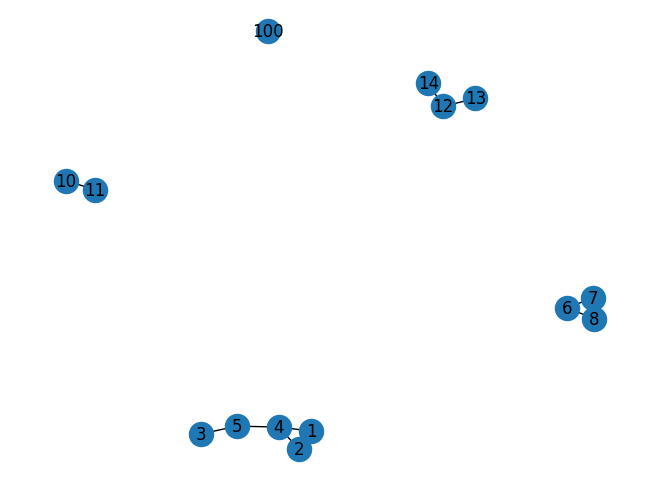

In [ ]:
nx.draw(graph,with_labels=True)

#Funcion generadora de colores

In [ ]:
def get_colors(conexas,pairs_,isolated):
  '''
  Params:
  conexas : dict of conect components
  pairs_ : list of tuple
  isolated : isolated points

  Return
  dict with colors as values and nodes as keys.
  '''
  colors_ = dict()
  ## componentes conexas
  for componente in conexas:
    color = custom_colors[randint(0,14)]
    for nodo in conexas[componente]:
      colors_[nodo[0]] = color

  ## pares
  for par in pairs_:
    color = custom_colors[randint(0,14)]
    colors_[par[0]], colors_[par[1]] = 'red', color

  ## puntos aislados
  for iso in isolated:
    colors_[iso] = 'red'

  return colors_

In [ ]:
#generando colores para cada componente
colores = get_colors(comp,pares_prueba, aislados)
colores

{3: (0.2941176470588235, 0.0, 0.5098039215686274),
 1: (0.2941176470588235, 0.0, 0.5098039215686274),
 2: (0.2941176470588235, 0.0, 0.5098039215686274),
 5: (0.2941176470588235, 0.0, 0.5098039215686274),
 4: (0.2941176470588235, 0.0, 0.5098039215686274),
 6: (1.0, 0.7137254901960784, 0.7568627450980392),
 7: (1.0, 0.7137254901960784, 0.7568627450980392),
 8: (1.0, 0.7137254901960784, 0.7568627450980392),
 13: (0.0, 0.0, 1.0),
 14: (0.0, 0.0, 1.0),
 12: (0.0, 0.0, 1.0),
 10: 'red',
 11: (0.0, 0.0, 1.0),
 100: 'red'}

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1062: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


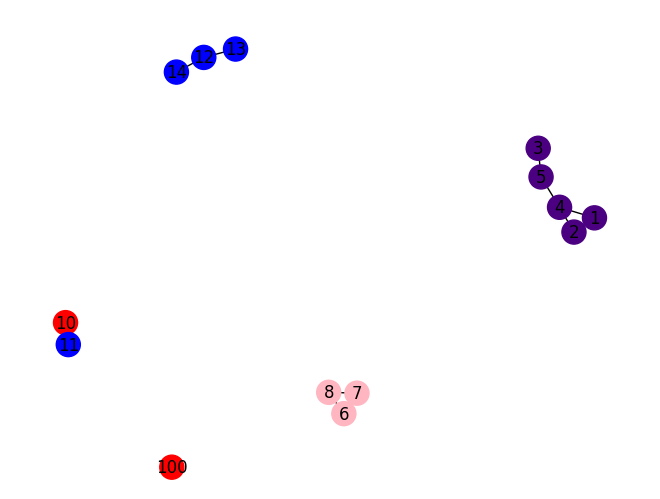

In [ ]:
colores_ = [colores[node] for node in graph.nodes() ]
nx.draw(graph,node_color=colores_,with_labels=True)

In [ ]:
colores = [color_per_node[nodo] for nodo in graph.nodes()]
# colores = color_per_node.values()
colores

[(0.5, 0.0, 0.5),
 (0.5, 0.0, 0.5),
 (0.5, 0.0, 0.5),
 (0.5, 0.0, 0.5),
 (0.5, 0.0, 0.5),
 (0.3725, 0.6196, 0.6275),
 (0.5, 0.0, 0.5),
 (0.5, 0.0, 0.5),
 (0.5, 0.0, 0.5),
 (0.5, 0.0, 0.5),
 (0.5, 0.0, 0.5),
 (0.3725, 0.6196, 0.6275),
 (0.3725, 0.6196, 0.6275),
 (0.3725, 0.6196, 0.6275)]

# Cargando la grafica

In [ ]:
conex_comp = pickle.load(open('componentes_conexas.pkl','rb'))
pairs =pickle.load(open('pares.pkl','rb'))
isolated_points = pickle.load(open('puntos_aislados.pkl','rb'))

In [ ]:
len(conex_comp), len(pairs), len(isolated_points)

(2777, 1300, 16333)

In [ ]:
conex_comp

{1: [(6538, 1), (8, 2), (16928, 2), (5784, 3)],
 2: [(1322, 1), (1323, 1), (1324, 1), (43, 3)],
 3: [(1551, 1), (1552, 1), (1553, 1), (44, 3)],
 4: [(45, 2), (2225, 2), (3558, 2), (19544, 2)],
 5: [(54, 3), (31839, 3), (31840, 3), (31841, 3), (4457, 3), (4965, 3)],
 6: [(79, 2), (1232, 2), (31637, 2)],
 7: [(12301, 1), (12347, 1), (12393, 1), (12439, 1), (83, 4)],
 8: [(29843, 1), (29844, 1), (89, 2)],
 9: [(112, 2), (17537, 2), (31651, 3), (31652, 3), (31653, 3), (31654, 3)],
 10: [(12960, 1), (18653, 1), (131, 2)],
 11: [(5358, 2),
  (5359, 2),
  (5360, 2),
  (5361, 2),
  (5362, 2),
  (5763, 2),
  (6344, 2),
  (141, 6),
  (6345, 8)],
 12: [(159, 2), (1731, 2), (3064, 2), (15844, 2)],
 13: [(29685, 1), (29686, 1), (178, 2)],
 14: [(183, 2), (25095, 2), (31098, 2)],
 15: [(187, 2), (2199, 2), (3532, 2), (19550, 2)],
 16: [(192, 2), (9627, 2), (18339, 2)],
 17: [(12311, 1), (12357, 1), (12403, 1), (12449, 1), (200, 4)],
 18: [(1574, 1),
  (2907, 1),
  (228, 2),
  (244, 3),
  (13114, 3),

## generando colores por componente

In [ ]:
colors = dict()
## componentes conexas
for componente in conex_comp.keys():
  color = choice(marker_colors)
  for nodo in conex_comp[componente]:
    colors[nodo[0]] = color

## pares
for par in pairs:
  color = choice(marker_colors)
  colors[par[0]], colors[par[1]] = 'red', color

## puntos aislados
for isolated in isolated_points:
  colors[isolated] = 'red'

Se utiliza un diccionario para guardar la pareja nodo:color ya que cuando grafiquemos iteraemos sobre este diccionario para ingresar al color de manera constante.
La funcion primero itera sobre cada componente en el diccionario y genera un color, con ese color iteramos sobre cada nodo de la componente conexa y en el diccionario agregamos el nodo y su valor asociado. Par las parejas y los puntos aislados se itera solo de manera lineal y se agrega el color rojo a un nodo de la pareja y a todos los puntos aislados, pues el rojo en este contexto significa que es vertice de corte


\noindent Notese que en tiempo nos toma $\Theta(n^2)$ por las componentes conexas y en espacio es $\Theta(n)$ por que se esta generando un unico diccionario de colores.

# Algoritmo para encontrar los vertices que desconectan la componente conexa

Primero inicializamos un diccionario vacio llamado ```cut_vertex``` que por cada componente como llave almacenara los vertices de corte

iteramos sobre cada componente conexa e inicializamos un diccionario vacio ```cut_vertex_comp``` donde guardaremos los vertices de corte de la componente, como los tenemos ordenados de menor grado a mayor grado dentro de una tupla el nodo con menor grado se encuentra en la posicion 0 de la lista y en la tupla en la posicion 0.

Una vez teniendo nuestro nodo con menor grado,  iteramos linealmente sobre sus vecinos y su color lo cambiamos a rojo, los agregamos a nuestro diccionario ```cut_vertex``` . Una vez que terminamos con sus vecinos, ese diccionario lo agregamos como valor en el diccionario ```cut_vertex```
y regresamos el diccionario de colores y el diccionario $cut\_vertex$ de vertices de corte por cada componente. Por lo tanto el algoritmo si es correcto


Como iteramos sobre todas las componentes conexas, esto lo hacemos de manera lineal, el acceder a nuestro nodo N es constante pues es la tupla en la posicion 0 y el nodo N esta en la posicion 0 dentro de la tupla, y el iterar sobre sus vecinos lo hacemos de manera lineal para poder marcarlos. Lo cual nos da una complejidad temporal de $\Theta(n^2)$ y una complejidad espacial de a lo mas $\Theta(n^2)$ pues el diccionario ```cut_vertex``` a lo mas tendra n componentes conexas con n vertices de corte.

In [ ]:
def disconex(G,components_,colors_):
  '''Parmas
  G : Graph to find the cut vertex
  components : dictionary of components
  colors : dictionary of colors per node

  Return
  The dictionary of colors with color red on the cut vertex
  '''
  cut_vertex = dict()
  for component in components_:
    cut_vertex_comp = dict()
    node = components_[component][0][0]
    # print('nodo:',node)
    for nei in G.adj[node]:
      # print('   vecinos',nei)
      colors_[nei] = 'red'
      cut_vertex_comp[nei] = None
    cut_vertex[component] = cut_vertex_comp
  return colors_, cut_vertex

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1062: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


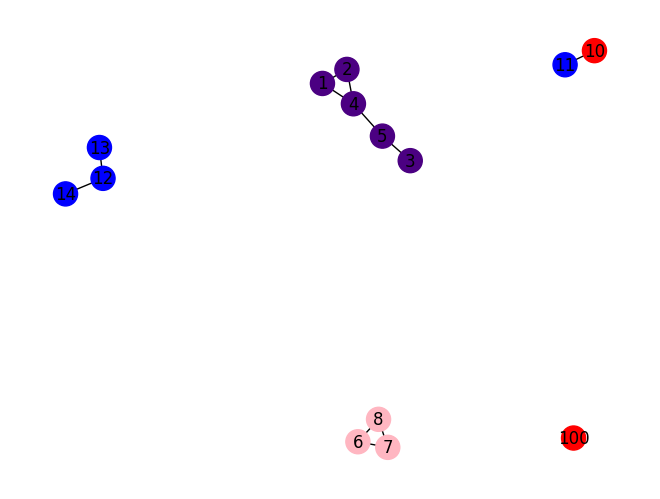

In [ ]:
nx.draw(graph,node_color=colores_, with_labels=True)

In [ ]:
colores, VC_graph = disconex(graph,comp,colores)
colores

{3: (0.2941176470588235, 0.0, 0.5098039215686274),
 1: (0.2941176470588235, 0.0, 0.5098039215686274),
 2: (0.2941176470588235, 0.0, 0.5098039215686274),
 5: 'red',
 4: (0.2941176470588235, 0.0, 0.5098039215686274),
 6: (1.0, 0.7137254901960784, 0.7568627450980392),
 7: 'red',
 8: 'red',
 13: (0.0, 0.0, 1.0),
 14: (0.0, 0.0, 1.0),
 12: 'red',
 10: 'red',
 11: (0.0, 0.0, 1.0),
 100: 'red'}

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1062: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


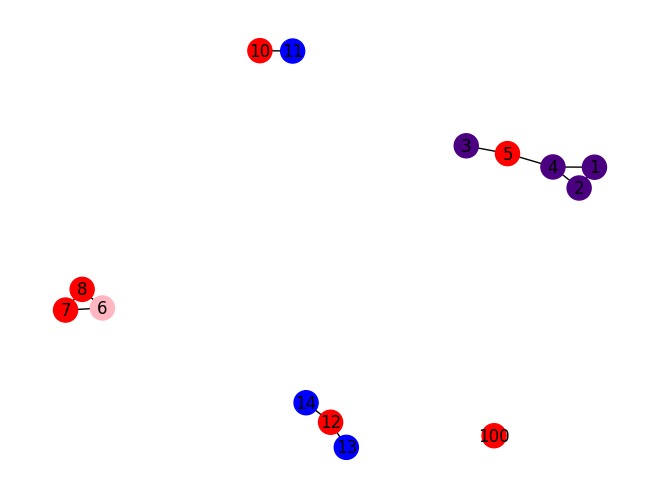

In [ ]:
nx.draw(graph,node_color=[colores[node] for node in graph.nodes()],with_labels=True)

# Grafica de componentes conexas

In [ ]:
gconexas = nx.read_graphml('grapfica5_coordenadas_org.graphml',node_type=int)
gconexas.remove_nodes_from(isolated_points)
print('numero de nodos no aislados: ',len(gconexas.nodes()))

numero de nodos no aislados:  16164


In [ ]:
m_CompConexa = folium.Map(location=(19.4361609, -99.1373136),zoom_start=12)

for id, coord in gconexas.nodes(data=True):
  folium.CircleMarker(location=[coord['latitud'],coord['longitud']],radius=5,fill=True,
                      fill_opacity=1,
                      fill_color = colors[id],
                      color=colors[id]).add_to(m_CompConexa)
  folium.Circle(location=[coord['latitud'],coord['longitud']], radius=35,
                color='red').add_to(m_CompConexa)

for id1, id2 in gconexas.edges():
  folium.PolyLine(locations=[pos[id1],pos[id2]],color=colors[id1]).add_to(m_CompConexa)


m_CompConexa.save('graficaComponentesConexas_colores.html')

In [ ]:
nx.write_graphml(gconexas,'graficaComponentesConexas_colores.graphml')

#algoritmo sobre la grafica de componentes conexas

In [ ]:
gconexas = nx.read_graphml('grapfica5_coordenadas_org.graphml',node_type=int)
gconexas.remove_nodes_from(isolated_points)

In [ ]:
m_CompConexaAlg = folium.Map(location=(19.4361609, -99.1373136),zoom_start=12)

##    aplicar la funcion disconex

colors_copy =colors.copy()
colors_copy,vertices =  disconex(gconexas,conex_comp,colors_copy)

for id, coord in gconexas.nodes(data=True):

  folium.CircleMarker(location=[coord['latitud'],coord['longitud']],radius=5,fill=True,
                      fill_opacity=1,
                      fill_color = colors[id],
                      color=colors_copy[id]).add_to(m_CompConexaAlg)
  folium.Circle(location=[coord['latitud'],coord['longitud']], radius=35,
                color='red').add_to(m_CompConexaAlg)

for id1, id2 in gconexas.edges():
  folium.PolyLine(locations=[pos[id1],pos[id2]],color=colors[id1]).add_to(m_CompConexaAlg)


m_CompConexaAlg.save('graficaComponentesConexasVerticesCorte_colores.html')

#Algoritmo sebre grafica completa





In [ ]:
m_CompletaCompConexa = folium.Map(location=(19.4361609, -99.1373136),zoom_start=12)
gcompleta = nx.read_graphml('grapfica5_coordenadas_org.graphml',node_type=int)

colors_copy =colors.copy()
colors_copy,vertices = disconex(gcompleta,conex_comp,colors_copy)

for id, coord in gcompleta.nodes(data=True):

  folium.CircleMarker(location=[coord['latitud'],coord['longitud']],radius=5,fill=True,
                      fill_opacity=1,
                      fill_color = colors[id],
                      color=colors_copy[id]).add_to(m_CompletaCompConexa)
  folium.Circle(location=[coord['latitud'],coord['longitud']], radius=35,
                color='red').add_to(m_CompletaCompConexa)

for id1, id2 in gcompleta.edges():
  folium.PolyLine(locations=[pos[id1],pos[id2]],color=colors[id1]).add_to(m_CompletaCompConexa)


m_CompletaCompConexa.save('graficaCompletaVerticesCorte_colores.html')

In [ ]:
print(vertices)

{1: {5784: None}, 2: {43: None}, 3: {44: None}, 4: {2225: None, 3558: None}, 5: {31839: None, 31840: None, 31841: None}, 6: {1232: None, 31637: None}, 7: {83: None}, 8: {89: None}, 9: {31651: None, 31652: None}, 10: {131: None}, 11: {141: None, 6345: None}, 12: {1731: None, 3064: None}, 13: {178: None}, 14: {25095: None, 31098: None}, 15: {2199: None, 3532: None}, 16: {9627: None, 18339: None}, 17: {200: None}, 18: {13114: None}, 19: {259: None, 552: None}, 20: {24974: None, 26580: None}, 21: {342: None}, 22: {346: None}, 23: {378: None}, 24: {385: None}, 25: {399: None}, 26: {427: None}, 27: {456: None}, 28: {465: None}, 29: {4455: None, 4963: None}, 30: {2429: None, 3762: None}, 31: {520: None}, 32: {557: None}, 33: {567: None}, 34: {614: None}, 35: {715: None, 717: None, 718: None}, 36: {600: None, 601: None, 602: None, 604: None, 605: None}, 37: {607: None, 608: None, 609: None, 610: None}, 38: {12482: None, 12528: None, 12574: None, 12620: None, 12666: None}, 39: {1826: None, 3159

In [ ]:
with open('VerticesCorte_PuntosWifi.pkl','wb') as fp:
  pickle.dump(vertices,fp)
  print('Vertices de corte guardados')

Vertices de corte guardados


#Grafica 2

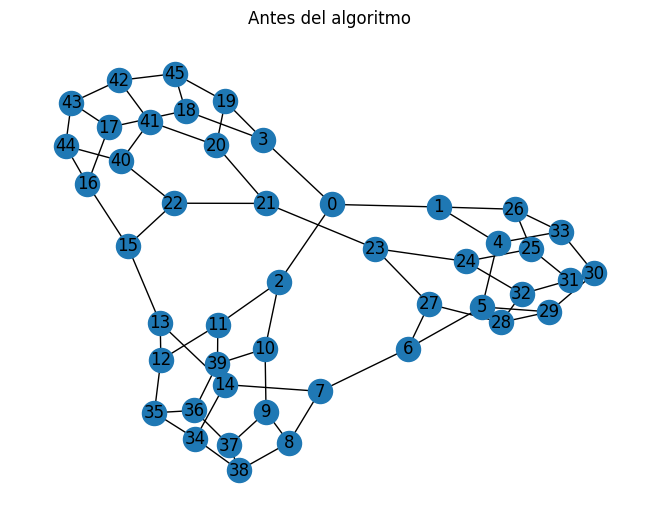

In [ ]:
gg = nx.tutte_graph()
nx.draw(gg,with_labels=True)
plt.title('Antes del algoritmo');

In [ ]:
Cconexas, paresgg, aisladosgg = componentes(gg)
colores_gg = get_colors(Cconexas,paresgg,aisladosgg)
_, VCgg = disconex(gg,Cconexas,colores_gg)
VCgg

{1: {1: None, 2: None, 3: None}}

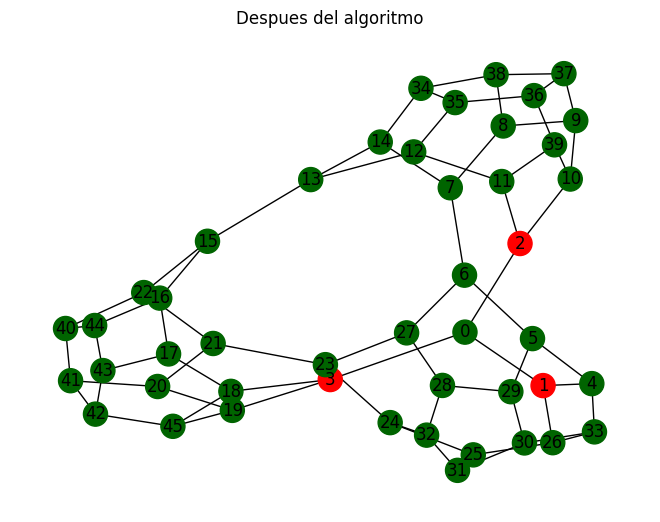

In [ ]:
nx.draw(gg,node_color=[colores_gg[nodo] for nodo in gg.nodes()],with_labels=True)
plt.title('Despues del algoritmo');

In [ ]:
gg.adj[0]

AtlasView({1: {}, 2: {}, 3: {}})

#Grafica 3

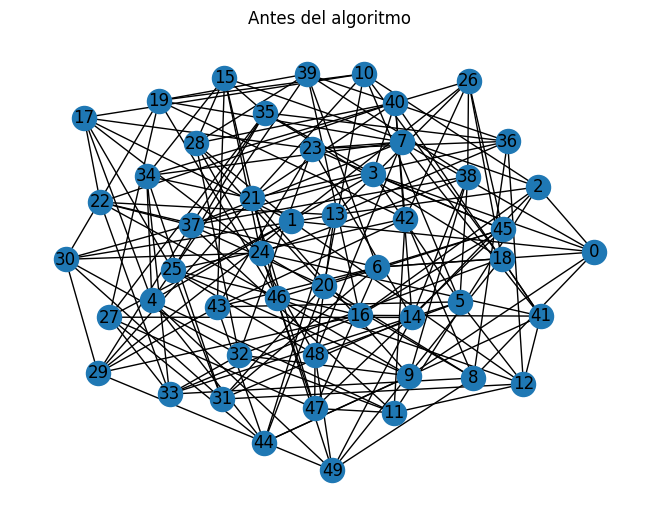

In [ ]:
tg = nx.hoffman_singleton_graph()
nx.draw(tg,with_labels=True)
plt.title('Antes del algoritmo');

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1062: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


{1: {1: None, 2: None, 3: None, 6: None, 7: None, 8: None, 9: None}}

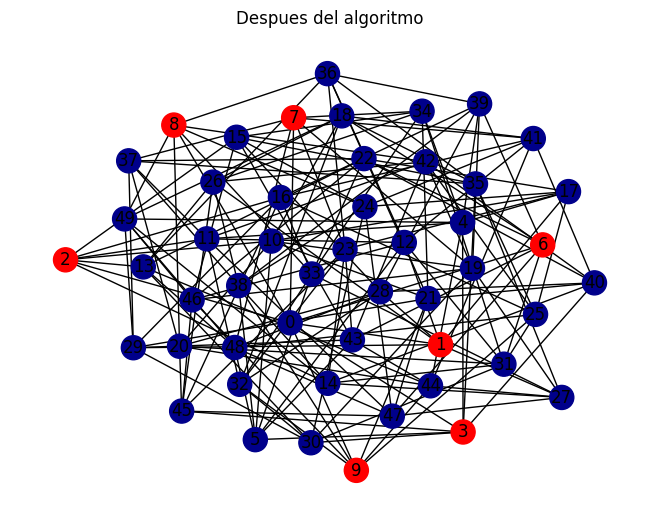

In [ ]:
Cconexas,pares,aislados_ = componentes(tg)
colores_tg = get_colors(Cconexas,pares,aislados_)
_, VCtg = disconex(tg,Cconexas,colores_tg)

nx.draw(tg,node_color=[colores_tg[nodo] for nodo in tg.nodes()],with_labels=True)
plt.title('Despues del algoritmo');
VCtg

In [ ]:
tg.adj[0]

AtlasView({1: {}, 2: {}, 3: {}, 6: {}, 7: {}, 8: {}, 9: {}})

# Grafica 4

[1, 2, 3, 4, 5, 7, 6, 8, 9, 0, 10, 11, 12, 13, 50]


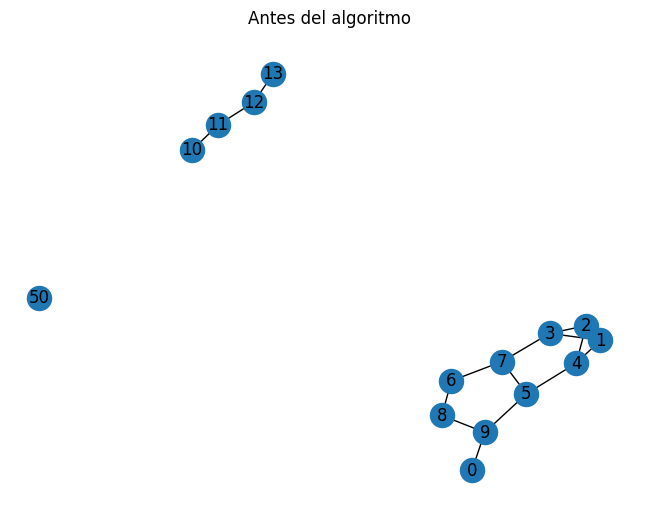

In [ ]:
g4 = nx.Graph()
# g4.add_edge(0,6)
g4.add_edge(1,2)
g4.add_edge(1,3)
g4.add_edge(1,4)
g4.add_edge(3,2)
g4.add_edge(4,2)
g4.add_edge(4,5)
g4.add_edge(5,7)
g4.add_edge(3,7)
g4.add_edge(6,7)
g4.add_edge(6,8)
g4.add_edge(8,9)
g4.add_edge(9,5)
g4.add_edge(0,9)

g4.add_edge(10,11)
g4.add_edge(11,12)
g4.add_edge(12,13)

g4.add_node(50)

nx.draw(g4,with_labels=True)
plt.title('Antes del algoritmo');
print(g4.nodes())

dict_keys([0, 6, 8, 1, 2, 3, 4, 7, 5, 9, 10, 13, 11, 12, 50])
dict_keys([0, 6, 8, 1, 2, 3, 4, 7, 5, 9, 10, 13, 11, 12, 50])


/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1062: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


{1: {9: None}, 2: {11: None}}

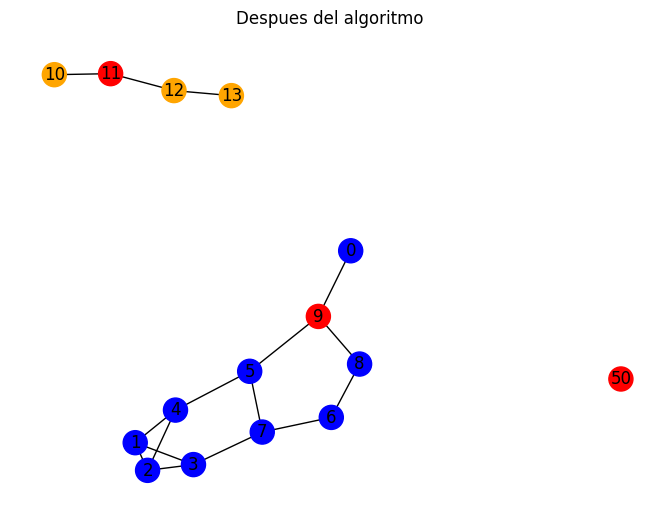

In [ ]:
Cconexasg4,paresg4,aisladosg4 = componentes(g4)
coloresg4 = get_colors(Cconexasg4,paresg4,aisladosg4)
print(coloresg4.keys())
_, VCg4 = disconex(g4,Cconexasg4,coloresg4)
print(coloresg4.keys())
nx.draw(g4,node_color=[coloresg4[nodo] for nodo in g4.nodes()],with_labels=True)
plt.title('Despues del algoritmo');
VCg4

#Grafica 5

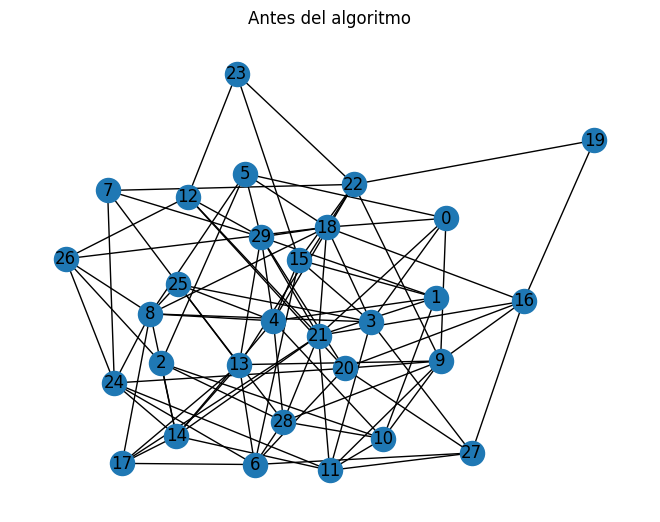

In [ ]:
g5 = nx.gnp_random_graph(30,0.2)
nx.draw(g5,with_labels=True)
plt.title('Antes del algoritmo');

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1062: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


{1: {16: None, 22: None}}

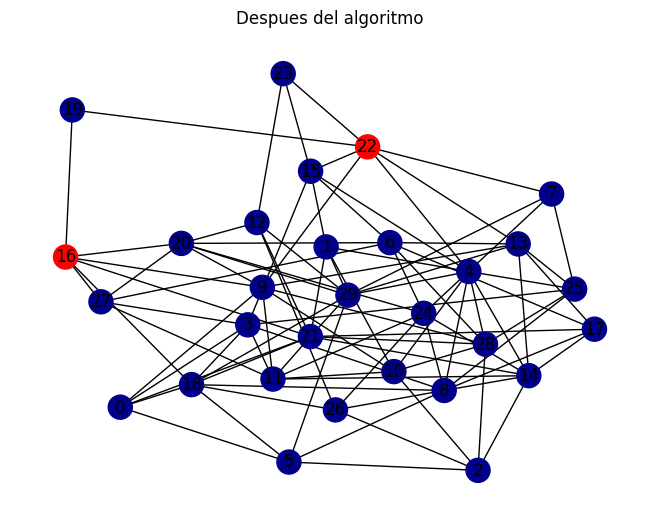

In [ ]:
conexasg5,paresg5,aisladosg5 = componentes(g5)
coloresg5 = get_colors(conexasg5,paresg5,aisladosg5)
_, VCg5 = disconex(g5,conexasg5,coloresg5)

nx.draw(g5,with_labels=True,node_color=[coloresg5[nodo] for nodo in g5.nodes()])
plt.title('Despues del algoritmo');
VCg5

In [ ]:
g5.adj[14]

AtlasView({1: {}, 4: {}, 8: {}, 16: {}, 19: {}})

#Grafica 6

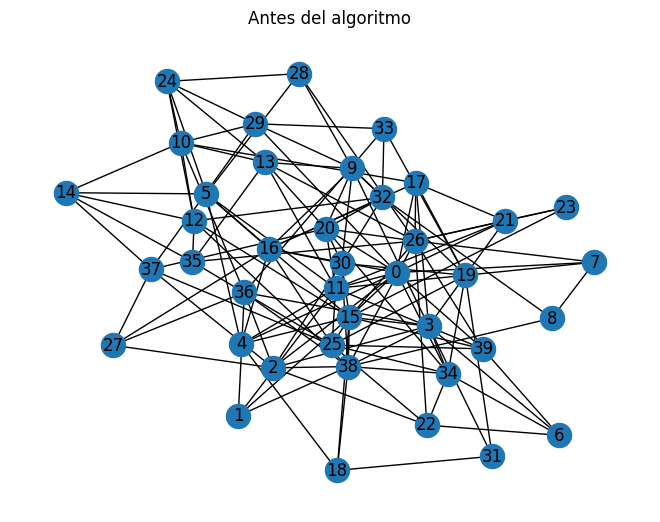

In [ ]:
g6 = nx.gnp_random_graph(40,0.2)
nx.draw(g6,with_labels=True)
plt.title('Antes del algoritmo');

{1: {7: None, 32: None, 38: None}}

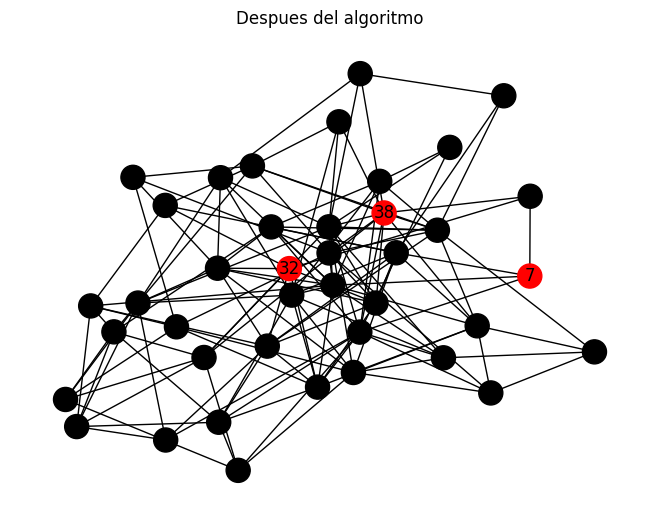

In [ ]:
conexasg6, paresg6, aisg6 = componentes(g6)
colorsg6 = get_colors(conexasg6,paresg6,aisg6)
_, VCg6 = disconex(g6,conexasg6,colorsg6)

nx.draw(g6,with_labels=True,node_color=[colorsg6[nodo] for nodo in g6.nodes()])
plt.title('Despues del algoritmo');
VCg6

In [ ]:
a =[(nodo,g6.degree[nodo]) for nodo in g6.nodes()]
a.sort(key=lambda x:x[1])
a

[(8, 3),
 (23, 3),
 (31, 3),
 (1, 4),
 (6, 4),
 (7, 4),
 (18, 4),
 (27, 4),
 (28, 4),
 (33, 4),
 (14, 5),
 (22, 5),
 (35, 5),
 (4, 6),
 (21, 6),
 (24, 6),
 (29, 6),
 (37, 6),
 (39, 6),
 (5, 7),
 (10, 7),
 (12, 7),
 (13, 7),
 (17, 7),
 (32, 7),
 (36, 7),
 (2, 8),
 (30, 8),
 (34, 8),
 (9, 9),
 (16, 9),
 (19, 9),
 (20, 9),
 (25, 9),
 (3, 10),
 (11, 10),
 (38, 11),
 (0, 12),
 (26, 12),
 (15, 13)]